![alt text](http://datascience.uci.edu/wp-content/uploads/sites/2/2014/09/data_science_logo_with_image1.png 'UCI_data_science')

# Advanced Predictive Modeling with Python 
## Session #2: Feature Engineering II
Author: [Eric Nalisnick](http://www.ics.uci.edu/~enalisni/)

### Schedule for Today

|Start Time | Session |
|-----------|---------|
|8:30am     | Check In|
|9:00am     | Feature Engineering I |
|10:30am    | Break |
|10:45am    | **Feature Engineering II** |
|12:30pm    | Lunch |
|12:30pm    | Feature Engineering III |
|12:30pm    | Break |
|12:30pm    | Ensembling |
|5:00pm    | End |

### Goals of this Lesson
- Gradient Descent for PCA
- Nonlinear Dimensionality Reduction
    - Autoencoder: Model and Learning
    - Autoencoding Images
    - Comparing Autoencoders and PCA

### References 
- [Ch. 14 'Autoencoders' of the *Deep Learning* book](http://www.deeplearningbook.org/contents/autoencoders.html)
- *Science* article on Autoencoders: [*Reducing the Dimensionality of Data with Neural Networks* by Hinton and  Salakhutdinov](https://www.cs.toronto.edu/~hinton/science.pdf)
- [SciKit-Learn's documentation on neural networks](http://scikit-learn.org/stable/modules/neural_networks_supervised.html)
- [SciKit-Learn's documentation on dimensionality reduction](http://scikit-learn.org/stable/modules/decomposition.html#decompositions)

## 0.  Preliminaries
First we need to import Numpy, Pandas, MatPlotLib...

In [2]:
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
%matplotlib inline

Again we need functions for shuffling the data and calculating classification errrors.  

In [3]:
### function for shuffling the data and labels
def shuffle_in_unison(features, labels):
    rng_state = np.random.get_state()
    np.random.shuffle(features)
    np.random.set_state(rng_state)
    np.random.shuffle(labels)
    
### calculate classification errors
# return a percentage: (number misclassified)/(total number of datapoints)
def calc_classification_error(predictions, class_labels):
    n = predictions.size
    num_of_errors = 0.
    for idx in xrange(n):
        if (predictions[idx] >= 0.5 and class_labels[idx]==0) or (predictions[idx] < 0.5 and class_labels[idx]==1):
            num_of_errors += 1
    return num_of_errors/n

### 0.1  Load the dataset of handwritten digits
We are going to use the Bob Ross paintings dataset throughout this session.  Let's again load the data and run PCA...  

Dataset size: 5000 x 784


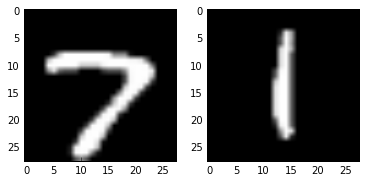

In [114]:
# load the 70,000 x 784 matrix
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original').data

# reduce to 5k instances
np.random.shuffle(mnist)
mnist = mnist[:5000,:]/255.
print "Dataset size: %d x %d"%(mnist.shape)

# subplot containing first image
ax1 = plt.subplot(1,2,1)
digit = mnist[1,:]
ax1.imshow(np.reshape(digit, (28, 28)), cmap='Greys_r')

# subplot containing second image
ax2 = plt.subplot(1,2,2)
digit = mnist[2,:]
ax2.imshow(np.reshape(digit, (28, 28)), cmap='Greys_r')
plt.show()

## 1 Gradient Descent for PCA

Recall the [Principal Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) model we covered in the last session.  Again, the goal of PCA is for a given datapoint $\mathbf{x}_{i}$, find a lower-dimensional representation $\mathbf{h}_{i}$ such that $\mathbf{x}_{i}$ can be 'predicted' from $\mathbf{h}_{i}$ using a linear transformation.  Again, the loss function can be written as: $$ = \sum_{i=1}^{N} (\mathbf{x}_{i} - \mathbf{x}_{i}\mathbf{W}\mathbf{W}^{T})^{2}.$$   



Now let's run PCA on the Bob Ross paintings dataset...
#### <span style="color:red">Caution: Running the following PCA code will take 2mins or more, depending on your computer's processing power.</span> 

In [122]:
# set the random number generator for reproducability
np.random.seed(49)

# define the dimensionality of the hidden rep.
n_components = 200

# Randomly initialize the Beta vector
W = np.random.uniform(low=-4 * np.sqrt(6. / (n_components + mnist.shape[1])),\
                      high=4 * np.sqrt(6. / (n_components + mnist.shape[1])), size=(mnist.shape[1], n_components))
# Initialize the step-size
alpha = 1e-3
# Initialize the gradient
grad = np.infty
# Set the tolerance 
tol = 1e-8
# Initialize error
old_error = 0
error = [np.infty]
batch_size = 250

### train with stochastic gradients
start_time = time.time()

iter_idx = 1
# loop until gradient updates become small
while (alpha*np.linalg.norm(grad) > tol) and (iter_idx < 300):
    for batch_idx in xrange(mnist.shape[0]/batch_size):
        x = mnist[batch_idx*batch_size:(batch_idx+1)*batch_size, :]
        h = np.dot(x, W)
        x_recon = np.dot(h, W.T)
        
        # compute gradient
        diff = x - x_recon
        grad = (-4./batch_size)*np.dot(diff.T, h)
    
        # update parameters
        W = W - alpha*grad
    
    # track the error
    if iter_idx % 25 == 0:
        old_error = error[-1]
        diff = mnist - np.dot(np.dot(mnist, W), W.T)
        recon_error = np.mean( np.sum(diff**2, 1) )
        error.append(recon_error)
        print "Epoch %d, Reconstruction Error: %.3f" %(iter_idx, recon_error)
    
    iter_idx += 1
end_time = time.time()

print
print "Training ended after %i iterations, taking a total of %.2f seconds." %(iter_idx, end_time-start_time)
print "Final Reconstruction Error: %.2f" %(error[-1])
reduced_mnist = np.dot(mnist, W)
print "Dataset is now of size: %d x %d"%(reduced_mnist.shape)

Epoch 25, Reconstruction Error: 193.564
Epoch 50, Reconstruction Error: 87.639
Epoch 75, Reconstruction Error: 52.889
Epoch 100, Reconstruction Error: 36.317
Epoch 125, Reconstruction Error: 26.897
Epoch 150, Reconstruction Error: 20.955
Epoch 175, Reconstruction Error: 16.935
Epoch 200, Reconstruction Error: 14.075
Epoch 225, Reconstruction Error: 11.962
Epoch 250, Reconstruction Error: 10.353
Epoch 275, Reconstruction Error: 9.097

Training ended after 300 iterations, taking a total of 27.04 seconds.
Final Reconstruction Error: 9.10
Dataset is now of size: 5000 x 200


Let's visualize a reconstruction...

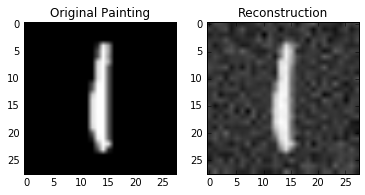

In [123]:
img_idx = 2
reconstructed_img = np.dot(reduced_mnist[img_idx,:], W.T)
original_img = mnist[img_idx,:]

# subplot for original image
ax1 = plt.subplot(1,2,1)
ax1.imshow(np.reshape(original_img, (28, 28)), cmap='Greys_r')
ax1.set_title("Original Painting")

# subplot for reconstruction
ax2 = plt.subplot(1,2,2)
ax2.imshow(np.reshape(reconstructed_img, (28, 28)), cmap='Greys_r')
ax2.set_title("Reconstruction")
plt.show()

We can also visualize the transformation matrix $\mathbf{W}^{T}$.  It's rows act as 'filters' or 'feature detectors'...

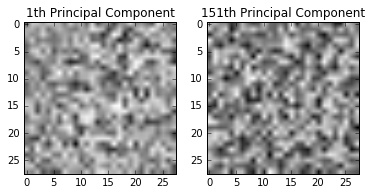

In [124]:
# two components to show
comp1 = 0
comp2 = 150

# subplot 
ax1 = plt.subplot(1,2,1)
filter1 = W[:, comp1]
ax1.imshow(np.reshape(filter1, (28, 28)), cmap='Greys_r')
ax1.set_title("%dth Principal Component"%(comp1+1))

# subplot 
ax2 = plt.subplot(1,2,2)
filter2 = W[:, comp2]
ax2.imshow(np.reshape(filter2, (28, 28)), cmap='Greys_r')
ax2.set_title("%dth Principal Component"%(comp2+1))
plt.show()

## 2.  Nonlinear Dimensionality Reduction with Autoencoders

In the last session we learned about *Principal Component Analysis*, a technique that finds some linear projection that reduces the dimensionality of the data while preserving its variance.  We looked at it as a form of unsupervised linear regression, where we predict the data itself instead of some associated value (i.e. a label).  In this session, we will briefly revist PCA and derive a gradient descent optimization procedure.  We will then move on to a *nonlinear* dimensionality reduction technique called an [Autoencoder](https://en.wikipedia.org/wiki/Autoencoder) and derive it's optimization procedure. 

### 0.1  Load the dataset of handwritten digits
We are going to use the Bob Ross paintings dataset throughout this session.  Let's again load the data and run PCA...  

In [191]:
# set the random number generator for reproducability
np.random.seed(39)

# define the dimensionality of the hidden rep.
n_components = 200

# Randomly initialize the Beta vector
W = np.random.uniform(low=-4 * np.sqrt(6. / (n_components + mnist.shape[1])),\
                      high=4 * np.sqrt(6. / (n_components + mnist.shape[1])), size=(mnist.shape[1], n_components))
b = np.zeros([1, n_components])

# Initialize the step-size
alpha = .01
# Initialize the gradient
grad_W = np.infty
# Set the tolerance 
tol = 1e-8
# Initialize error
old_error = 0
error = [np.infty]
batch_size = 250

### train with stochastic gradients
start_time = time.time()

def logistic(x):
    return 1./(1+np.exp(-x))

def logistic_derivative(x):
    z = logistic(x)
    return np.multiply(z, 1-z)

iter_idx = 1
# loop until gradient updates become small
while (alpha*np.linalg.norm(grad) > tol) and (iter_idx < 300):
    for batch_idx in xrange(mnist.shape[0]/batch_size):
        x = mnist[batch_idx*batch_size:(batch_idx+1)*batch_size, :]
        pre_act = np.dot(x, W) #+ b
        h = logistic(pre_act)
        x_recon = np.dot(h, W.T)
        
        # compute gradient
        diff = x - x_recon
        grad = (-2./batch_size)*(np.dot(diff.T, h) + np.dot(np.multiply(np.dot(diff, W), logistic_derivative(pre_act)).T, x).T)
    
        # update parameters
        W = W - alpha*grad
    
    # track the error
    if iter_idx % 25 == 0:
        old_error = error[-1]
        
        diff = mnist - np.dot(logistic(np.dot(mnist, W)), W.T)
        recon_error = np.mean( np.sum(diff**2, 1) )
        error.append(recon_error)
        print "Epoch %d, Reconstruction Error: %.3f" %(iter_idx, recon_error)
    
    iter_idx += 1
end_time = time.time()

print
print "Training ended after %i iterations, taking a total of %.2f seconds." %(iter_idx, end_time-start_time)
print "Final Reconstruction Error: %.2f" %(error[-1])
reduced_mnist = np.dot(mnist, W)
print "Dataset is now of size: %d x %d"%(reduced_mnist.shape)

Epoch 25, Reconstruction Error: 51.391
Epoch 50, Reconstruction Error: 42.625
Epoch 75, Reconstruction Error: 36.876
Epoch 100, Reconstruction Error: 33.029
Epoch 125, Reconstruction Error: 29.827
Epoch 150, Reconstruction Error: 26.926
Epoch 175, Reconstruction Error: 24.672
Epoch 200, Reconstruction Error: 22.810
Epoch 225, Reconstruction Error: 21.200
Epoch 250, Reconstruction Error: 19.822
Epoch 275, Reconstruction Error: 18.626

Training ended after 300 iterations, taking a total of 51.91 seconds.
Final Reconstruction Error: 18.63
Dataset is now of size: 5000 x 200


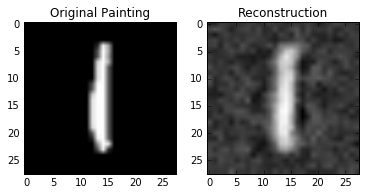

In [192]:
img_idx = 2
reconstructed_img = np.dot(logistic(reduced_mnist[img_idx,:]), W.T)
original_img = mnist[img_idx,:]

# subplot for original image
ax1 = plt.subplot(1,2,1)
ax1.imshow(np.reshape(original_img, (28, 28)), cmap='Greys_r')
ax1.set_title("Original Painting")

# subplot for reconstruction
ax2 = plt.subplot(1,2,2)
ax2.imshow(np.reshape(reconstructed_img, (28, 28)), cmap='Greys_r')
ax2.set_title("Reconstruction")
plt.show()

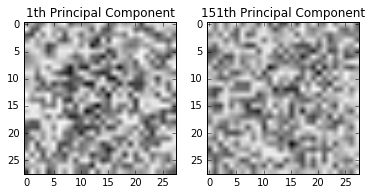

In [193]:
# two components to show
comp1 = 0
comp2 = 150

# subplot 
ax1 = plt.subplot(1,2,1)
filter1 = W[:, comp1]
ax1.imshow(np.reshape(filter1, (28, 28)), cmap='Greys_r')

# subplot 
ax2 = plt.subplot(1,2,2)
filter2 = W[:, comp2]
ax2.imshow(np.reshape(filter2, (28, 28)), cmap='Greys_r')
plt.show()

### 0.1  SciKit Learn Version
We are going to use the Bob Ross paintings dataset throughout this session.  Let's again load the data and run PCA...  

In [200]:
from sklearn.neural_network import MLPRegressor

# set the random number generator for reproducability
np.random.seed(39)

# define the dimensionality of the hidden rep.
n_components = 200

# define model
ae = MLPRegressor(hidden_layer_sizes=(n_components,), activation='logistic')

### train Autoencoder
start_time = time.time()
ae.fit(mnist, mnist)
end_time = time.time()

recon_error = np.mean(np.sum((mnist - ae.predict(mnist))**2, 1))
W = ae.coefs_[0]
b = ae.intercepts_[0]
reduced_mnist = logistic(np.dot(mnist, W) + b)

print
print "Training ended after a total of %.2f seconds." %(end_time-start_time)
print "Final Reconstruction Error: %.2f" %(recon_error)
print "Dataset is now of size: %d x %d"%(reduced_mnist.shape)


Training ended after a total of 12.20 seconds.
Final Reconstruction Error: 5.77
Dataset is now of size: 5000 x 200


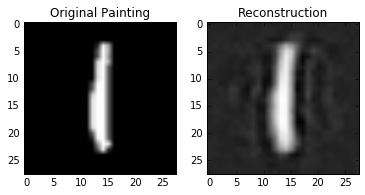

In [204]:
img_idx = 5
reconstructed_img = np.dot(reduced_mnist[img_idx,:], ae.coefs_[1]) + ae.intercepts_[1]
original_img = mnist[img_idx,:]

# subplot for original image
ax1 = plt.subplot(1,2,1)
ax1.imshow(np.reshape(original_img, (28, 28)), cmap='Greys_r')
ax1.set_title("Original Painting")

# subplot for reconstruction
ax2 = plt.subplot(1,2,2)
ax2.imshow(np.reshape(reconstructed_img, (28, 28)), cmap='Greys_r')
ax2.set_title("Reconstruction")
plt.show()

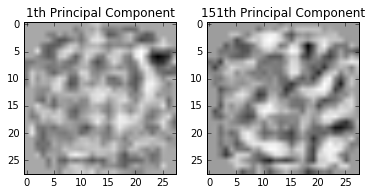

In [205]:
# two components to show
comp1 = 0
comp2 = 150

# subplot 
ax1 = plt.subplot(1,2,1)
filter1 = W[:, comp1]
ax1.imshow(np.reshape(filter1, (28, 28)), cmap='Greys_r')
ax1.set_title("%dth Principal Component"%(comp1+1))

# subplot 
ax2 = plt.subplot(1,2,2)
filter2 = W[:, comp2]
ax2.imshow(np.reshape(filter2, (28, 28)), cmap='Greys_r')
ax2.set_title("%dth Principal Component"%(comp2+1))
plt.show()

### 0.1  Denoising Autoencoder
We are going to use the Bob Ross paintings dataset throughout this session.  Let's again load the data and run PCA...  

In [220]:
# set the random number generator for reproducability
np.random.seed(39)

# define the dimensionality of the hidden rep.
n_components = 200

# Randomly initialize the Beta vector
W = np.random.uniform(low=-4 * np.sqrt(6. / (n_components + mnist.shape[1])),\
                      high=4 * np.sqrt(6. / (n_components + mnist.shape[1])), size=(mnist.shape[1], n_components))
b = np.zeros([1, n_components])

# Initialize the step-size
alpha = .01
# Initialize the gradient
grad_W = np.infty
# Set the tolerance 
tol = 1e-8
# Initialize error
old_error = 0
error = [np.infty]
batch_size = 250

### train with stochastic gradients
start_time = time.time()

def logistic(x):
    return 1./(1+np.exp(-x))

def logistic_derivative(x):
    z = logistic(x)
    return np.multiply(z, 1-z)

iter_idx = 1
# loop until gradient updates become small
while (alpha*np.linalg.norm(grad) > tol) and (iter_idx < 300):
    for batch_idx in xrange(mnist.shape[0]/batch_size):
        x = mnist[batch_idx*batch_size:(batch_idx+1)*batch_size, :]
        x_corrupt = np.multiply(x, np.random.binomial(n=1, p=.5, size=x.shape))
        pre_act = np.dot(x, W) 
        h = logistic(pre_act)
        x_recon = np.dot(h, W.T)
        
        # compute gradient
        diff = x - x_recon
        grad = (-2./batch_size)*(np.dot(diff.T, h) + np.dot(np.multiply(np.dot(diff, W), logistic_derivative(pre_act)).T, x_corrupt).T)
    
        # update parameters
        W = W - alpha*grad
    
    # track the error
    if iter_idx % 25 == 0:
        old_error = error[-1]
        
        diff = mnist - np.dot(logistic(np.dot(mnist, W)), W.T)
        recon_error = np.mean( np.sum(diff**2, 1) )
        error.append(recon_error)
        print "Epoch %d, Reconstruction Error: %.3f" %(iter_idx, recon_error)
    
    iter_idx += 1
end_time = time.time()

print
print "Training ended after %i iterations, taking a total of %.2f seconds." %(iter_idx, end_time-start_time)
print "Final Reconstruction Error: %.2f" %(error[-1])
reduced_mnist = np.dot(mnist, W)
print "Dataset is now of size: %d x %d"%(reduced_mnist.shape)

Epoch 25, Reconstruction Error: 42.307
Epoch 50, Reconstruction Error: 29.004
Epoch 75, Reconstruction Error: 22.219
Epoch 100, Reconstruction Error: 18.171
Epoch 125, Reconstruction Error: 15.503
Epoch 150, Reconstruction Error: 13.644
Epoch 175, Reconstruction Error: 12.274
Epoch 200, Reconstruction Error: 11.219
Epoch 225, Reconstruction Error: 10.380
Epoch 250, Reconstruction Error: 9.696
Epoch 275, Reconstruction Error: 9.128

Training ended after 300 iterations, taking a total of 86.89 seconds.
Final Reconstruction Error: 9.13
Dataset is now of size: 5000 x 200


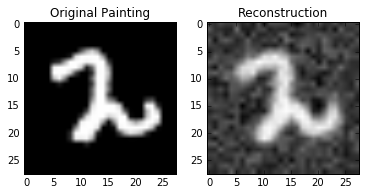

In [223]:
img_idx = 5
reconstructed_img = np.dot(logistic(reduced_mnist[img_idx,:]), W.T)
original_img = mnist[img_idx,:]

# subplot for original image
ax1 = plt.subplot(1,2,1)
ax1.imshow(np.reshape(original_img, (28, 28)), cmap='Greys_r')
ax1.set_title("Original Painting")

# subplot for reconstruction
ax2 = plt.subplot(1,2,2)
ax2.imshow(np.reshape(reconstructed_img, (28, 28)), cmap='Greys_r')
ax2.set_title("Reconstruction")
plt.show()

![alt text](https://i.imgur.com/mg86tIg.png)

## <span style="color:red">STUDENT ACTIVITY (until end of session)</span> 
Your task is to reproduce the above PCA examples on a new dataset of images.  Let's load it...

In [ ]:
from sklearn.datasets import fetch_olivetti_faces

faces_dataset = fetch_olivetti_faces(shuffle=True)
faces = faces_dataset.data # 400 flattened 64x64 images
person_ids = faces_dataset.target # denotes the identity of person (40 total)

print "Dataset size: %d x %d" %(faces.shape)
print "And the images look like this..."
plt.imshow(np.reshape(faces[200,:], (64, 64)), cmap='Greys_r')
plt.show()

This dataset contains 400 64x64 pixel images of 40 people each exhibiting 10 facial expressions.  The images are in gray-scale, not color, and therefore flattened vectors contain 4096 dimensions.

### <span style="color:red">Subtask 1: Run (Regular) Autoencoder</span> 

In [ ]:
### Your code goes here ###

# train Autoencoder model on 'faces'

###########################

print "Training took a total of %.2f seconds." %(end_time-start_time)
print "Final reconstruction error: %.2f%%" %(recon_error) 
print "Dataset is now of size: %d x %d"%(faces_reduced.shape)

### <span style="color:red">Subtask 2: Reconstruct an image</span> 

In [ ]:
### Your code goes here ###

# Use learned transformation matrix to project back to the original 4096-dimensional space
# Remember you need to use np.reshape() 

###########################

Your output should look something like what's below (although could be a different face):
![reconstruction_solution](./graphics/face_reconstruction_soln.png)

### <span style="color:red">Subtask 3: Train a Denoising Autoencoder</span> 

In [ ]:
### Your code goes here ###


###########################

### <span style="color:red">Subtask 4: Generate a 2D scatter plot from both models</span> 

In [ ]:
### Your code goes here ###

# Run AE for 2 components

# Generate plot

# Bonus: color the scatter plot according to the person_ids to see if any structure can be seen

###########################